<a href="https://colab.research.google.com/github/LorenzoTarricone/Mathemaical-Modelling-in-Machine-Learning/blob/main/09_MLP_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Multilayer Perceptron from scratch

We will implement a few basic blocks needed to create and train a MLP:

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other activation function to introduce non-linearity)
- Loss function - (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropagated gradients

Let's approach them one at a time.

## Imports

Let's start by importing some libraires required for creating our neural network.

In [ ]:
import numpy as np
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass *.forward()* and Backward pass *.backward().*

In [ ]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    - Process input to get output:           output = layer.forward(input)
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    Some layers also have learnable parameters which they update during layer.backward.
    """
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        # We define __call__ for convenience, so that we can use our layer as a function
        return self.forward(x)
    
    def forward(self, x):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        return x

    def backward(self, x, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input. 
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        return (grad_output,)

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [ ]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, x):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0, x)
        return relu_forward
    
    def backward(self, x, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = x > 0
        return (grad_output * relu_grad,)
    
def test_relu():
    batch_size = 16
    n_in = 10 
    x = np.random.randn(batch_size, n_in)
    relu = ReLU()
    y = relu(x)
    assert y.shape == (16, 10) 
    assert (y >= 0).all() 

test_relu()

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. We are using **Xavier initialization** : we initialize our weights with mean zero and variance of `2 / (n_in + n_out)`

In [ ]:
class Dense(Layer):
    """
    A dense layer is a layer which performs a learned affine transformation:
    f(x) = W*x + b
    
    
    input shape: [batch, n_in]
    output shape: [batch, n_out units]
    """
    def __init__(self, nin, nout):
        self.weights = np.random.normal(loc = 0.0, 
                                        scale = np.sqrt(2/(nin + nout)), 
                                        size = (nin, nout))
        self.biases = np.zeros(nout)
                                        
        
    def forward(self,x):
        return x @ self.weights + self.biases
    
    def backward(self, x, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output @ self.weights.T
        
        # compute gradient w.r.t. weights and biases
        grad_weights = x.T @ grad_output
        grad_biases = grad_output.sum(axis=0)
        
        return grad_input, grad_weights, grad_biases
    
def test_dense():
    batch_size = 16
    nout = 5 
    nin = 3 
    x = np.random.randn(batch_size, nin)
    dense = Dense(nin, nout)
    y = dense(x)
    assert y.shape == (batch_size, nout) 
    
    gout = np.random.randn(batch_size, nout)
    gx, gw, gb = dense.backward(x, gout)
    assert gx.shape == x.shape
    assert gw.shape == dense.weights.shape
    assert gb.shape == dense.biases.shape

test_dense()

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [ ]:
def softmax_crossentropy_with_logits(logits, y):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    # This is advance indexing with numpy int arrays as indexes
    # See https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
    logits_for_answers = logits[np.arange(len(logits)), y]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
    
    return np.mean(xentropy) # mean over the batch

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. As I have told earlier, we are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

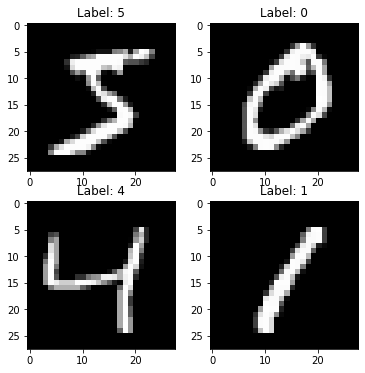

In [ ]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [ ]:
class MLP:
    def __init__(self, nin=28*28, nhidden=100, nout=10):
        layers = []
        layers.append(Dense(nin, nhidden))
        layers.append(ReLU())
        layers.append(Dense(nhidden, nhidden))
        layers.append(ReLU())
        layers.append(Dense(nhidden, nout))
        self.layers = layers
        self.activations = None

    def forward(self, X):
        """
        Compute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        """
        self.activations = [X]
        # Looping through each layer
        for l in self.layers:
            X = l(X)
            self.activations.append(X)
        return X
            
    def __len__(self):
        return len(self.layers)

    def __getitem__(self, i):
        return self.layers[i]

    def predict(self, X):
        """
        Compute network predictions. Returning indices of largest Logit probability
        """
        logits = self.forward(X)
        return logits.argmax(axis=-1)

    def train(self, X, y, learning_rate=0.1):
        """
        Train our network on a given batch of X and y.
        We first need to run forward to get all layer activations.
        Then we can run layer.backward going from last to first layer.
        Going back, use the returned gradients to update the layer's weights and biases with a GD step.
        """

        # Get the layer activations
        logits = self.forward(X)
        activations = self.activations
        
        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits, y)
        input_grad = grad_softmax_crossentropy_with_logits(logits, y)

        # Propagate gradients through the self
        # Reverse propogation as this is backprop
        for layer_index in range(len(self.layers))[::-1]:
            layer = self.layers[layer_index]
            output_grad = input_grad
            res_back = layer.backward(activations[layer_index], input_grad) #grad w.r.t. input, also weight updates
            input_grad = res_back[0]
            if len(res_back) > 1:
                gW, gb = res_back[1], res_back[2]
                # # Here we perform a gradient descent step. 
                layer.weights = layer.weights - learning_rate * gW
                layer.biases = layer.biases - learning_rate * gb

        return loss


### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [ ]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    else:
        indices = np.arange(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        idxs = indices[start_idx:start_idx + batchsize]
        yield inputs[idxs], targets[idxs]

Epoch 9
Train accuracy: 0.99474
Val accuracy: 0.9747


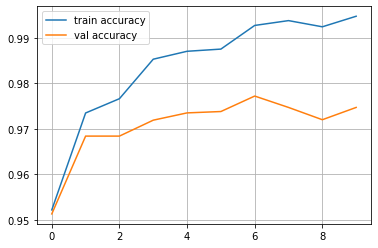

In [ ]:
from IPython.display import clear_output
train_log = []
val_log = []
network = MLP()


epochs = 10

for epoch in range(epochs):

    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        network.train(x_batch, y_batch)
    
    train_log.append(np.mean(network.predict(X_train) == y_train))
    val_log.append(np.mean(network.predict(X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

As we can see we have successfully trained a MLP which was purely written in numpy with high validation accuracy!